# 1. 神经网络结构设计与调优
在人工构造的MNIST数据集的子集上进行训练/测试，要求：

（1）参考课件中给出的代码，实现以下两种不同的网络结构（要求用numpy手动实现前向传播和反向传播等过程）：
- 2层前馈网络，激活函数sigmoid或tanh，隐含层维度自定
- 3层前馈网络，激活函数relu，隐含层维度自定

（2）两个网络在测试集上分类准确率均$\ge$85%

（3）画出训练过程中训练集上loss和训练集上accuracy的变化曲线

本次作业可能涉及到的激活函数的定义及其导函数：
- $sigmoid(x)=1/(1+e^{-x})$, 导函数$sigmoid(x)(1-sigmoid(x))$
- $tanh(x)=(e^x-e^{-x})/(e^x+e^{-x})$，导函数$1-tanh^2(x)$
- $relu(x)=max(0,x)$，导函数$f(x)=\begin{cases}1, x>0 \\ 0, x\le0\end{cases}$

（附加）调优上一步实现的网络：
- batch size，iteration
- loss function（MSE，交叉熵……）
- 优化器的参数（学习率，学习率调整策略，优化器类型……）
- 网络权重初始化策略
- 数据预处理/增强

<font color=ff0000> ⚠️截止日期 5.16 中午 11:59，如果做了附加题调优，请在作业中注释出调优部分。⚠️</font>

In [2]:
# 读取训练和测试数据
# 本次作业为加快训练速度，只取1000个样本作为训练集，200个样本作为测试集
# 每个样本原本是28*28的图片，reshape成784维向量输入神经网络
# 只取（形状比较相近的）数字8和数字9两个类，做二分类，并将数字8的label重新标为0，数字9的label重新标为1
# 两个类的训练样本数不均衡（1:3）
# 本部分代码不可修改

import numpy as np
f = np.load('mnist.npz') 
x_train, y_train = f['x_train'], f['y_train'] 
x_test, y_test = f['x_test'], f['y_test'] 

def get_small_data(x_data, y_data, num1, num2):
    cnt1, cnt2, final_x, final_y = 0, 0, [], []
    for i in range(x_data.shape[0]):
        x = x_data[i, :].reshape(-1).tolist()
        y = y_data[i]
        if y == 8 and cnt1 < num1:
            final_x.append(x)
            final_y.append(0)
            cnt1 += 1
        elif y == 9 and cnt2 < num2:
            final_x.append(x)
            final_y.append(1)
            cnt2 += 1
    return np.array(final_x), np.array(final_y)

x_train, y_train = get_small_data(x_train, y_train, num1=250, num2=750)
x_test, y_test = get_small_data(x_test, y_test, num1=100, num2=100)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1000, 784)
(1000,)
(200, 784)
(200,)


In [3]:
# 数据预处理：归一化操作
x_train = np.concatenate((x_train, np.ones((x_train.shape[0], 1))), axis=1)
x_train = x_train/255
x_test = np.concatenate((x_test, np.ones((x_test.shape[0], 1))), axis=1)
x_test = x_test/255
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def grad_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x):
    return (np.exp(x)-np.exp(-x)) / (np.exp(x)+np.exp(-x))

def grad_tanh(x):
    return 1 - tanh(x)**2

def relu(x):
    return np.where(x >= 0, x, 0)

def grad_relu(x):
    return np.where(x >= 0, 1, 0)

def entropy(y1, y2):
    return np.sum(y2*np.log(y1)+(1-y2)*np.log(1-y1))/y_train.shape[0]

def mse(y1, y2):
    return np.sum(((y1-y2)**2)/2)/y_train.shape[0]

In [307]:
def nn(w1, w2, batch_num):
    cur_train = x_train[batch_size*batch_num:batch_size*(batch_num+1),:]
    cur_label = y_train[batch_size*batch_num:batch_size*(batch_num+1)].reshape(-1, 1)
    z_1 = np.dot(cur_train, w1)
    a_1 = sigmoid(z_1)
    z_2 = np.dot(a_1, w2)
    y_pred = sigmoid(z_2)

    w2_g = np.dot(a_1.T, (y_pred-cur_label)*grad_sigmoid(z_2))
    w1_g = np.dot(cur_train.T, np.dot((y_pred-cur_label)*grad_sigmoid(z_2), w2.T)*grad_sigmoid(z_1))
    grad = {'w1': w1_g, 'w2': w2_g}
    return y_pred, cur_label, grad
    

In [308]:
w1 = np.random.uniform(low=-1, high=1, size=(785, 60))
w2 = np.random.uniform(low=-1, high=1, size=(60, 1))
# 增加iteration数，学习效果更好
epoch_num = 200
# batch size设为100，小批量训练增加权重更新次数
batch_size = 100
learning_rate = 0.002
loss_val, accu = [], []

In [309]:
# TODO
# 2层前馈网络，以sigmoid作为激活函数
for epoch in range(epoch_num):
    loss_val_epoch, acc = 0, 0
    for batch in range(x_train.shape[0]//batch_size):
        y_pred, y_label, grad = nn(w1, w2, batch)
        
        w1 = w1 - learning_rate*grad['w1']
        w2 = w2 - learning_rate*grad['w2']
        # 交叉熵损失函数
        loss_val_epoch += (-entropy(y_pred, y_label))
        acc += np.sum((y_pred>=0.5) == y_label)
    
    loss_val.append(loss_val_epoch)
    accu.append(acc/y_train.shape[0])
    if epoch % 10 == 9:
        print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch, loss_val[-1], accu[-1]))

Epoch: 9, Loss: 0.8296510730905836, Accuracy: 0.734
Epoch: 19, Loss: 0.4626045713580833, Accuracy: 0.784
Epoch: 29, Loss: 0.29248579113808054, Accuracy: 0.888
Epoch: 39, Loss: 0.2282188717452571, Accuracy: 0.928
Epoch: 49, Loss: 0.19490862376037352, Accuracy: 0.942
Epoch: 59, Loss: 0.17406025188194654, Accuracy: 0.954
Epoch: 69, Loss: 0.1594804466482443, Accuracy: 0.959
Epoch: 79, Loss: 0.14850726205991754, Accuracy: 0.963
Epoch: 89, Loss: 0.13980612300339712, Accuracy: 0.964
Epoch: 99, Loss: 0.13263589311043933, Accuracy: 0.966
Epoch: 109, Loss: 0.12655276570425372, Accuracy: 0.967
Epoch: 119, Loss: 0.1212748456374051, Accuracy: 0.969
Epoch: 129, Loss: 0.1166142625772635, Accuracy: 0.97
Epoch: 139, Loss: 0.11244067385787675, Accuracy: 0.972
Epoch: 149, Loss: 0.10866052869997475, Accuracy: 0.973
Epoch: 159, Loss: 0.1052047264487699, Accuracy: 0.974
Epoch: 169, Loss: 0.10202097070799261, Accuracy: 0.977
Epoch: 179, Loss: 0.09906887077959609, Accuracy: 0.978
Epoch: 189, Loss: 0.096316709

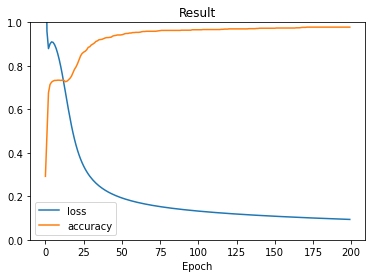

In [310]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(loss_val, label="loss")
plt.plot(accu, label="accuracy")
plt.title("Result")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [311]:
# TODO
# 2层前馈网络test集上准确率
y_pred_test = sigmoid(np.dot(sigmoid(np.dot(x_test, w1)), w2))
accu_test = np.sum((y_pred_test >= 0.5) == y_test.reshape(-1,1))/y_test.shape[0]
print("Test accuracy: {}".format(accu_test))

Test accuracy: 0.915


In [71]:
# TODO
# 3层前馈网络，以relu作为激活函数

In [19]:
def nn3relu(w1, w2, w3, batch_num):
    cur_train = x_train[batch_size*batch_num:batch_size*(batch_num+1),:]
    cur_label = y_train[batch_size*batch_num:batch_size*(batch_num+1)].reshape(-1, 1)
    z_1 = np.dot(cur_train, w1)
    a_1 = relu(z_1)
    z_2 = np.dot(a_1, w2)
    a_2 = relu(z_2)
    z_3 = np.dot(a_2, w3)
    y_pred = np.where(z_3>0, 1, 0)

    w3_g = np.dot(a_2.T, (y_pred-cur_label))
    w2_g = np.dot(a_1.T, np.dot((y_pred-cur_label), w3.T)*grad_relu(z_2))
    w1_g = np.dot(cur_train.T, np.dot(np.dot((y_pred-cur_label), w3.T)*grad_relu(z_2), w2.T)*grad_relu(z_1))
    grad = {'w1': w1_g, 'w2': w2_g, 'w3': w3_g}
    return y_pred, cur_label, grad
    

In [32]:
w1 = np.random.uniform(low=-1, high=1, size=(785, 256))
w2 = np.random.uniform(low=-1, high=1, size=(256, 32))
w3 = np.random.uniform(low=-1, high=1, size=(32, 1))
epoch_num = 200
batch_size = 100
# 减小learning-rate，避免relu神经元出现dead情况
learning_rate = 1e-5
loss_val, accu = [], []

In [33]:
for epoch in range(epoch_num):
    loss_val_epoch, acc = 0, 0
    for batch in range(x_train.shape[0]//batch_size):
        y_pred, y_label, grad = nn3relu(w1, w2, w3, batch)
        
        w1 = w1 - learning_rate*grad['w1']
        w2 = w2 - learning_rate*grad['w2']
        w3 = w3 - learning_rate*grad['w3']
        # MSE损失函数
        loss_val_epoch += (mse(y_pred, y_label))
        acc += np.sum((y_pred>=0.5) == y_label)
    
    loss_val.append(loss_val_epoch)
    accu.append(acc/y_train.shape[0])
    if epoch % 10 == 9:
        print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch, loss_val[-1], accu[-1]))

Epoch: 9, Loss: 0.08900000000000002, Accuracy: 0.822
Epoch: 19, Loss: 0.05600000000000001, Accuracy: 0.888
Epoch: 29, Loss: 0.038000000000000006, Accuracy: 0.924
Epoch: 39, Loss: 0.031, Accuracy: 0.938
Epoch: 49, Loss: 0.030000000000000006, Accuracy: 0.94
Epoch: 59, Loss: 0.0245, Accuracy: 0.951
Epoch: 69, Loss: 0.020500000000000004, Accuracy: 0.959
Epoch: 79, Loss: 0.018000000000000002, Accuracy: 0.964
Epoch: 89, Loss: 0.018000000000000002, Accuracy: 0.964
Epoch: 99, Loss: 0.013000000000000001, Accuracy: 0.974
Epoch: 109, Loss: 0.014000000000000002, Accuracy: 0.972
Epoch: 119, Loss: 0.013500000000000002, Accuracy: 0.973
Epoch: 129, Loss: 0.015, Accuracy: 0.97
Epoch: 139, Loss: 0.013000000000000001, Accuracy: 0.974
Epoch: 149, Loss: 0.010500000000000002, Accuracy: 0.979
Epoch: 159, Loss: 0.012, Accuracy: 0.976
Epoch: 169, Loss: 0.0095, Accuracy: 0.981
Epoch: 179, Loss: 0.008, Accuracy: 0.984
Epoch: 189, Loss: 0.006000000000000002, Accuracy: 0.988
Epoch: 199, Loss: 0.007000000000000001,

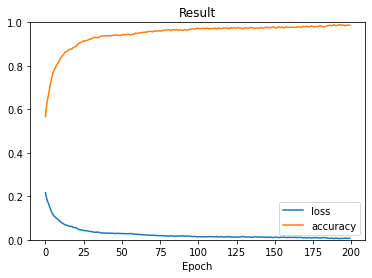

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(loss_val, label="loss")
plt.plot(accu, label="accuracy")
plt.title("Result")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [35]:
# TODO
# 3层前馈网络test集上准确率
y_pred_test = np.dot(relu(np.dot(relu(np.dot(x_test, w1)), w2)), w3)
y_pred_test = np.where(y_pred_test>0, 1, 0)
accu_test = 1-np.sum(np.logical_xor(y_pred_test, y_test.reshape(-1,1)))/y_test.shape[0]
print("Test accuracy: {}".format(accu_test))

Test accuracy: 0.885
